In [1]:
%matplotlib inline

import datetime
import joblib
import json
import keras
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import seaborn as sns

from IPython.display import display, HTML
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, GRU, Input
from keras.layers.recurrent import LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from matplotlib.gridspec import GridSpec
from numpy import hstack
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, RobustScaler
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.optimizers import Adam

# Make the graphs a bit prettier, and bigger
matplotlib.style.use('ggplot')

In [2]:
import tensorflow as tf
import tensorflow.compat.v1.keras.backend as K

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
# config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

K.set_session(sess)

In [3]:
cfg = {
    'model_name': 'm2-incr-nostl',
    'teacher_forcing': False,
    'units': 60,
    'droupout_rate': 0.6,
    'remove_peak': False,
    'differential': False,
    'forecast_steps': 1,
    'forecast_len': 1,
    'test_stl': False,
    'stl_period': 24,
    'train': {
        'data_file': os.path.join('data', 'buffer-all-1M.tsv'),
        'epochs': 100,
        'epochs_incremental': 2,
        'epochs_patience': 10
    },
    'tsg': {
        'length': 24,
        'sampling_rate': 1,
        'stride': 1,
        'batch_size': 1
    },
    'data': {
        'split': 0.8,
        'X': [
            'conn_count_uid_in',
            'conn_count_uid_out',
            'dns_count_uid_out',
            'http_count_uid_in',
            'ssl_count_uid_in'
        ],
        'Y': [
            'conn_count_uid_in',
            'conn_count_uid_out',
            'dns_count_uid_out',
            'http_count_uid_in',
            'ssl_count_uid_in'
        ]
    }
}

In [4]:
def split_df(df:pd.DataFrame, split:float=0.7) -> pd.DataFrame:
    rows = df.shape[0]
    at = int(split * rows)
    return df[:at], df[at:]

def differentiate(df:pd.DataFrame, k) -> pd.DataFrame:
    return df[k:]-df[:-k].values

def inverse_differentiate(df:pd.DataFrame, seen:pd.DataFrame, k) -> pd.DataFrame:
    return seen.values+df

def transform(df:pd.DataFrame) -> pd.DataFrame:
    if cfg['differential']:
        return differentiate(df, cfg['forecast_steps'])
    else:
        return df

def inverse_transform(df:pd.DataFrame, df_orig:pd.DataFrame) -> pd.DataFrame:
    if cfg['differential']:
        return df + df_orig[cfg['tsg']['length']+cfg['forecast_steps']-1:-cfg['forecast_steps']].values
    else:
        return df

# read data from file
data_df = pd.read_csv(cfg['train']['data_file'], sep='\t')
data_df = data_df.set_index('ts')
data_df.index = pd.to_datetime(data_df.index)

# select data
cols = list(set(cfg['data']['X']+cfg['data']['Y']))
cols.sort()
data_df = data_df[cols]

# interpolate missing data
data_df = data_df.interpolate(method="time")

# split data
data_df_train, data_df_test = split_df(data_df, split=cfg['data']['split'])

data_df_train_X = data_df_train[cfg['data']['X']]
data_df_train_Y = data_df_train[cfg['data']['Y']]

data_df_test_X = data_df_test[cfg['data']['X']]
data_df_test_Y = data_df_test[cfg['data']['Y']]

data_df_train_X_t = transform(data_df_train_X)
data_df_train_Y_t = transform(data_df_train_Y)
data_df_test_X_t = transform(data_df_test_X)
data_df_test_Y_t = transform(data_df_test_Y)

data_np_train_X = data_df_train_X_t.values.astype('float32')
data_np_train_Y = data_df_train_Y_t.values.astype('float32')

data_np_test_X = data_df_test_X_t.values.astype('float32')
data_np_test_Y = data_df_test_Y_t.values.astype('float32')

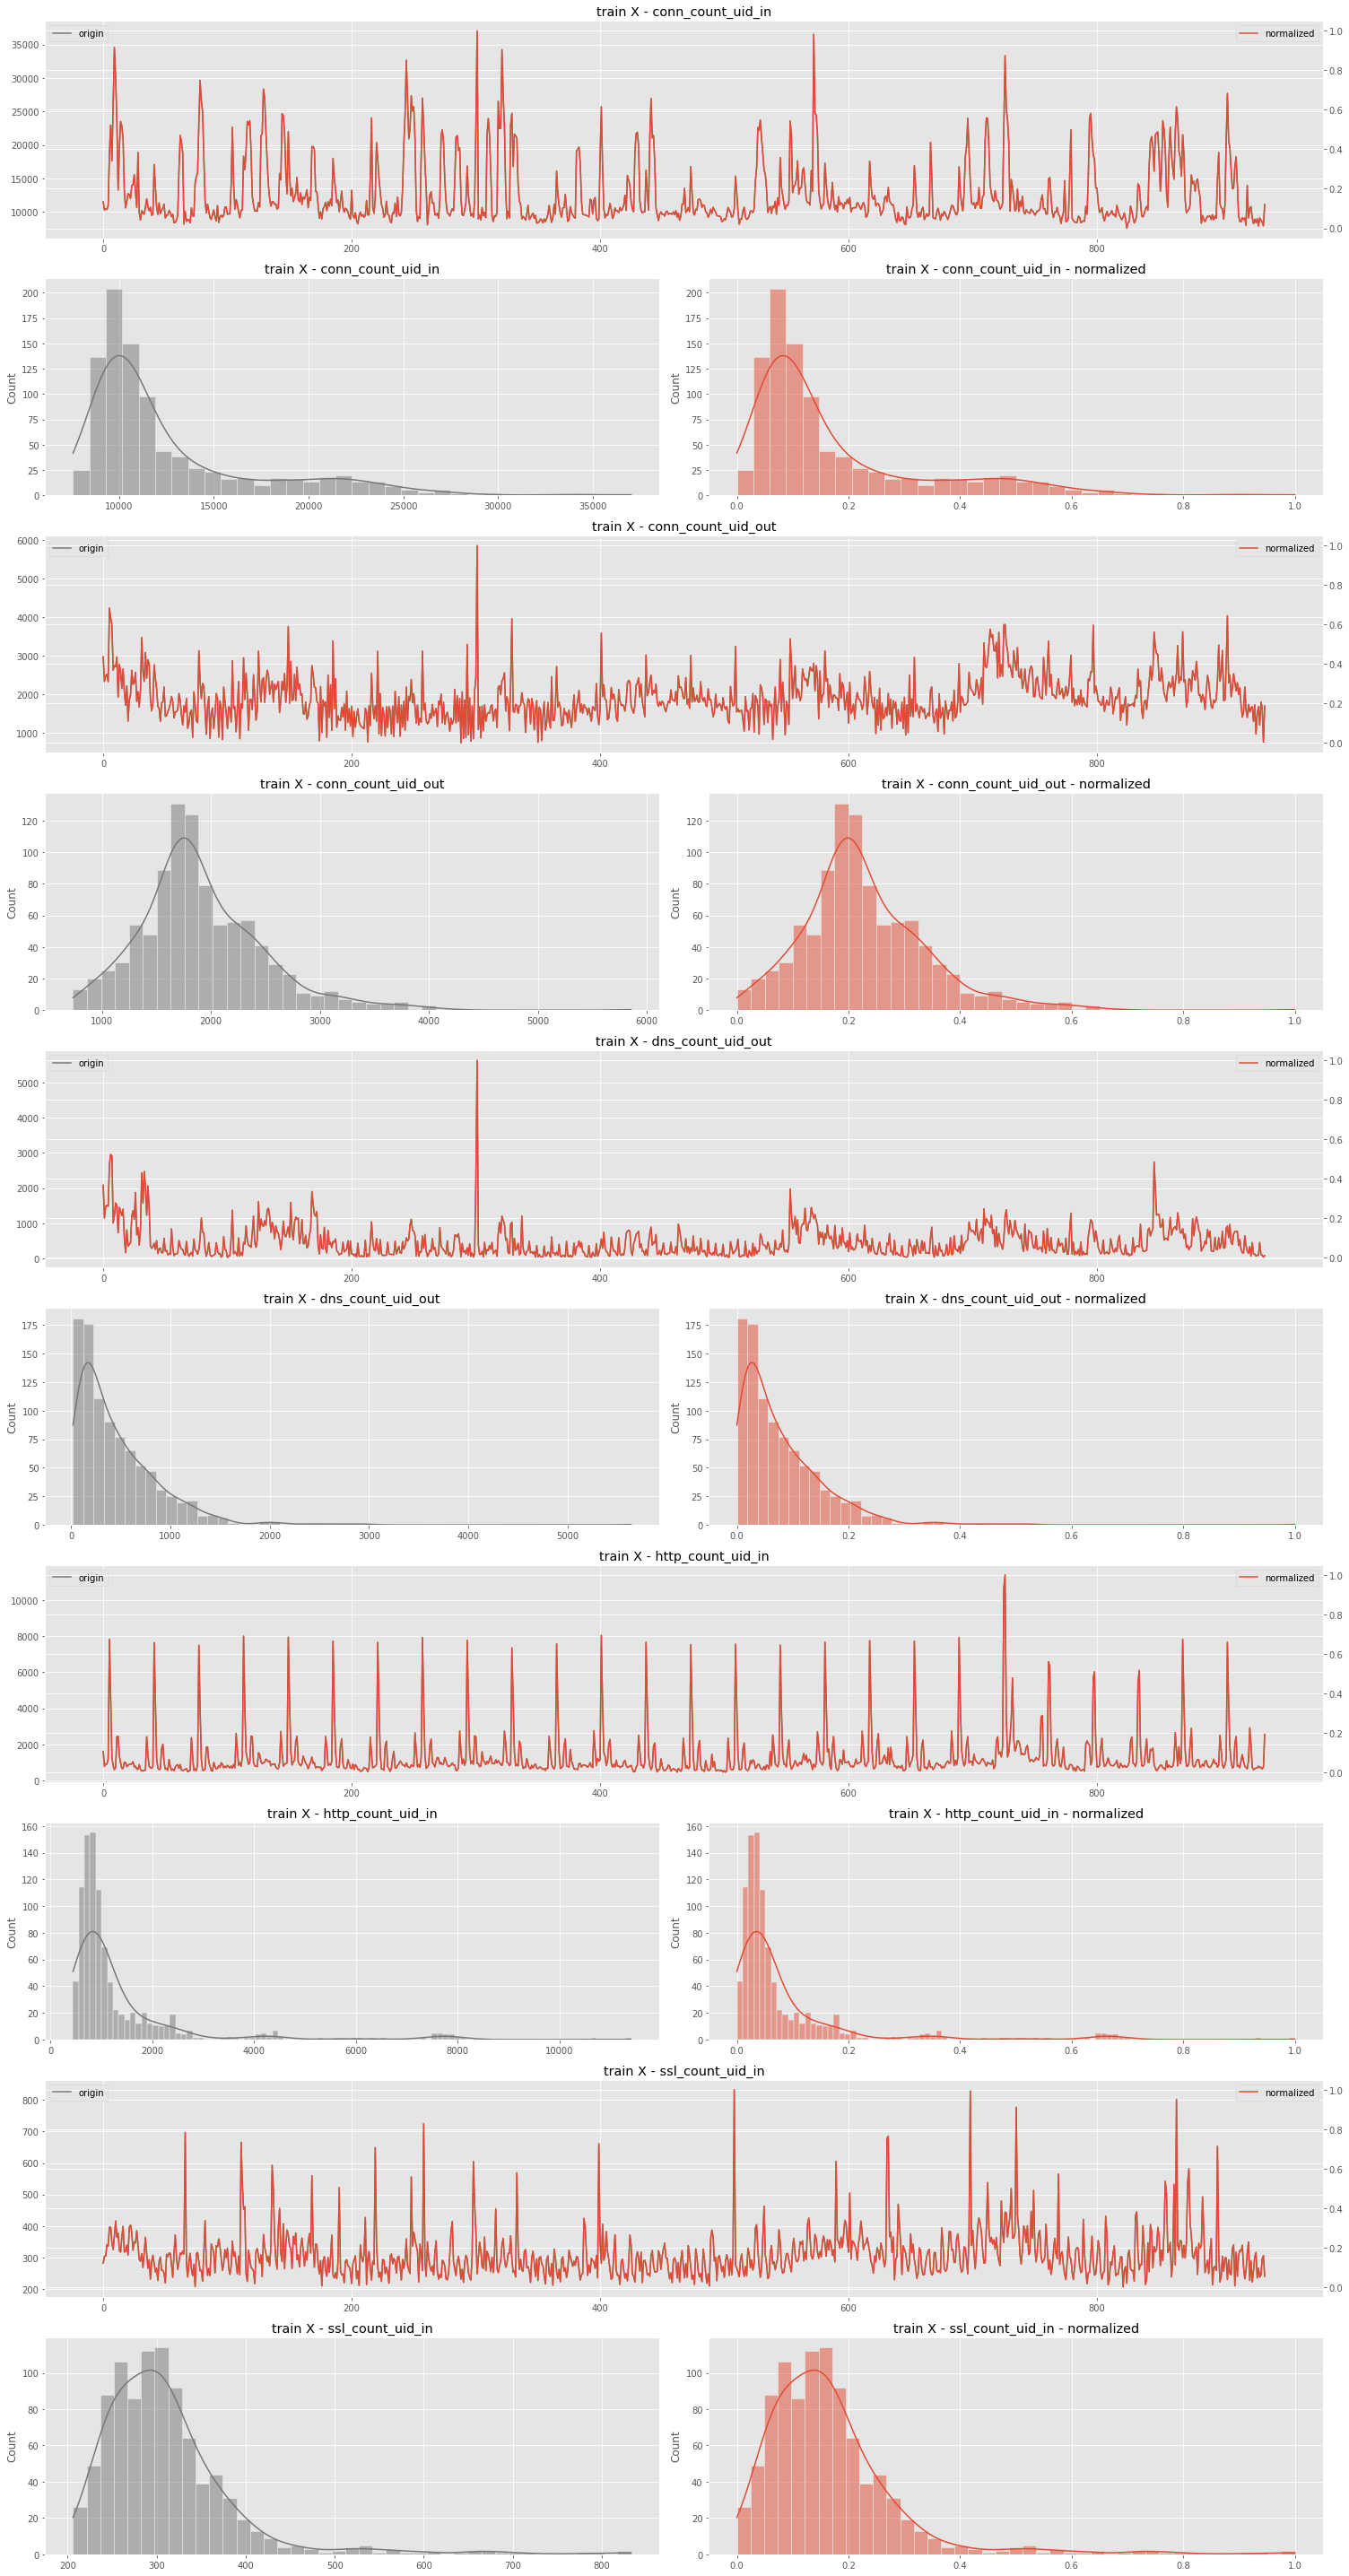

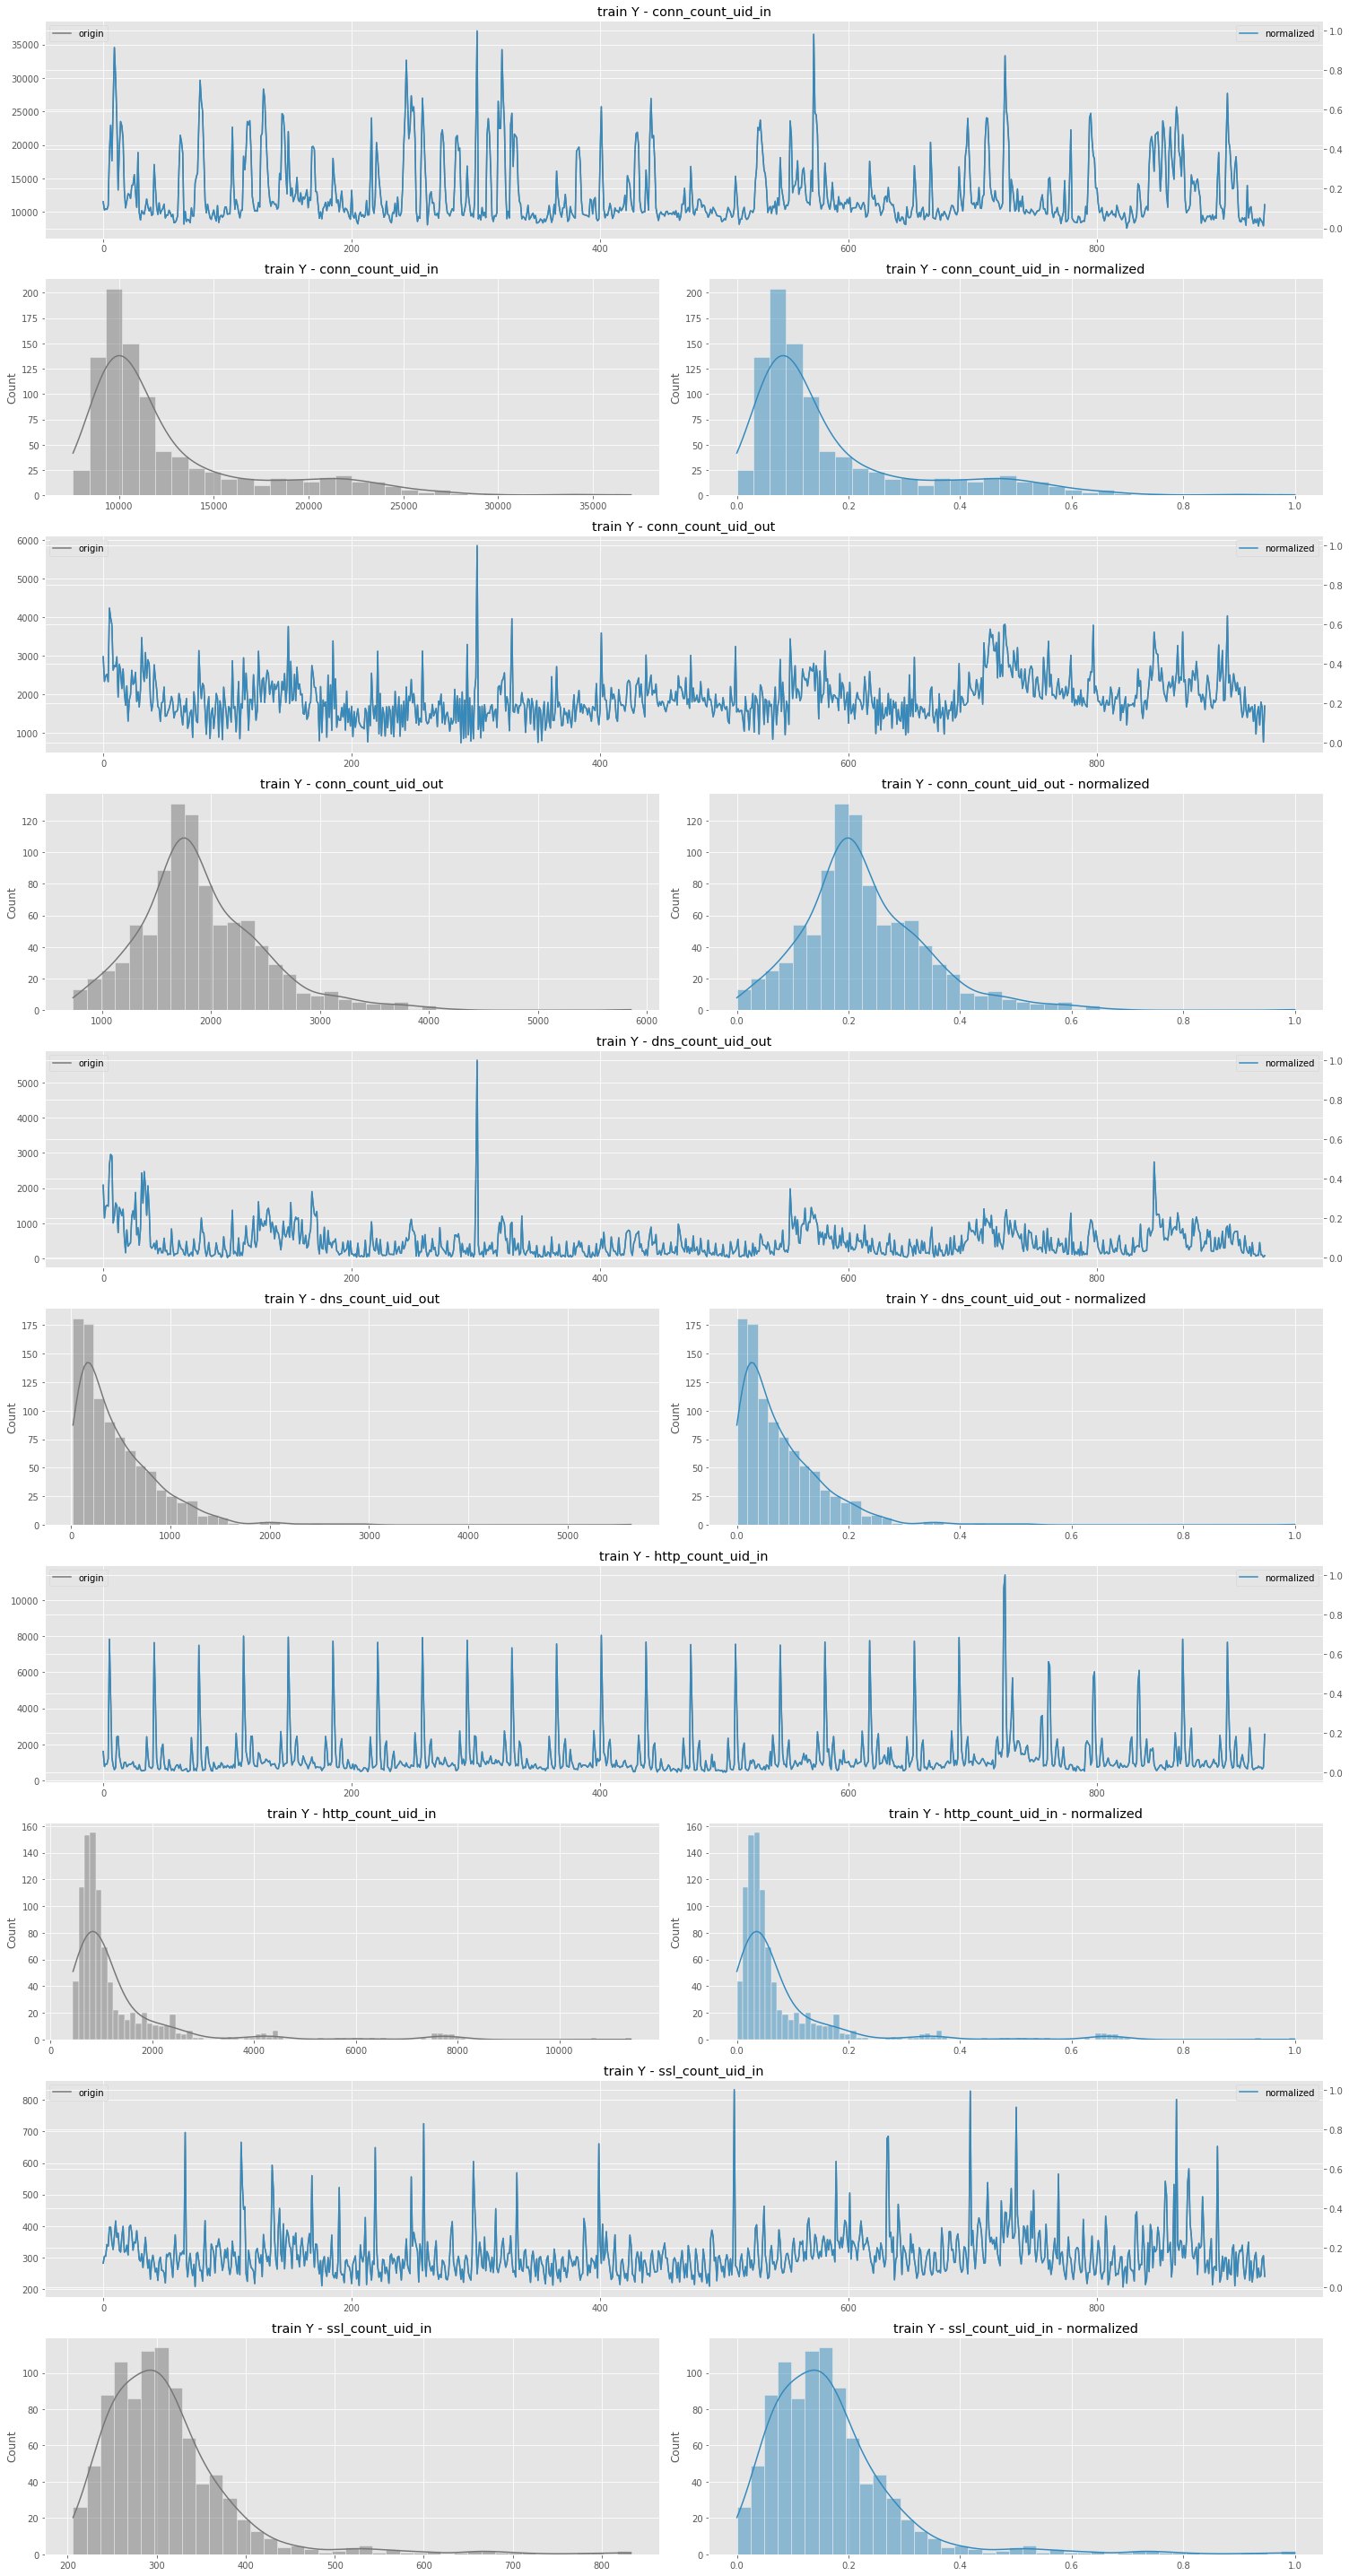

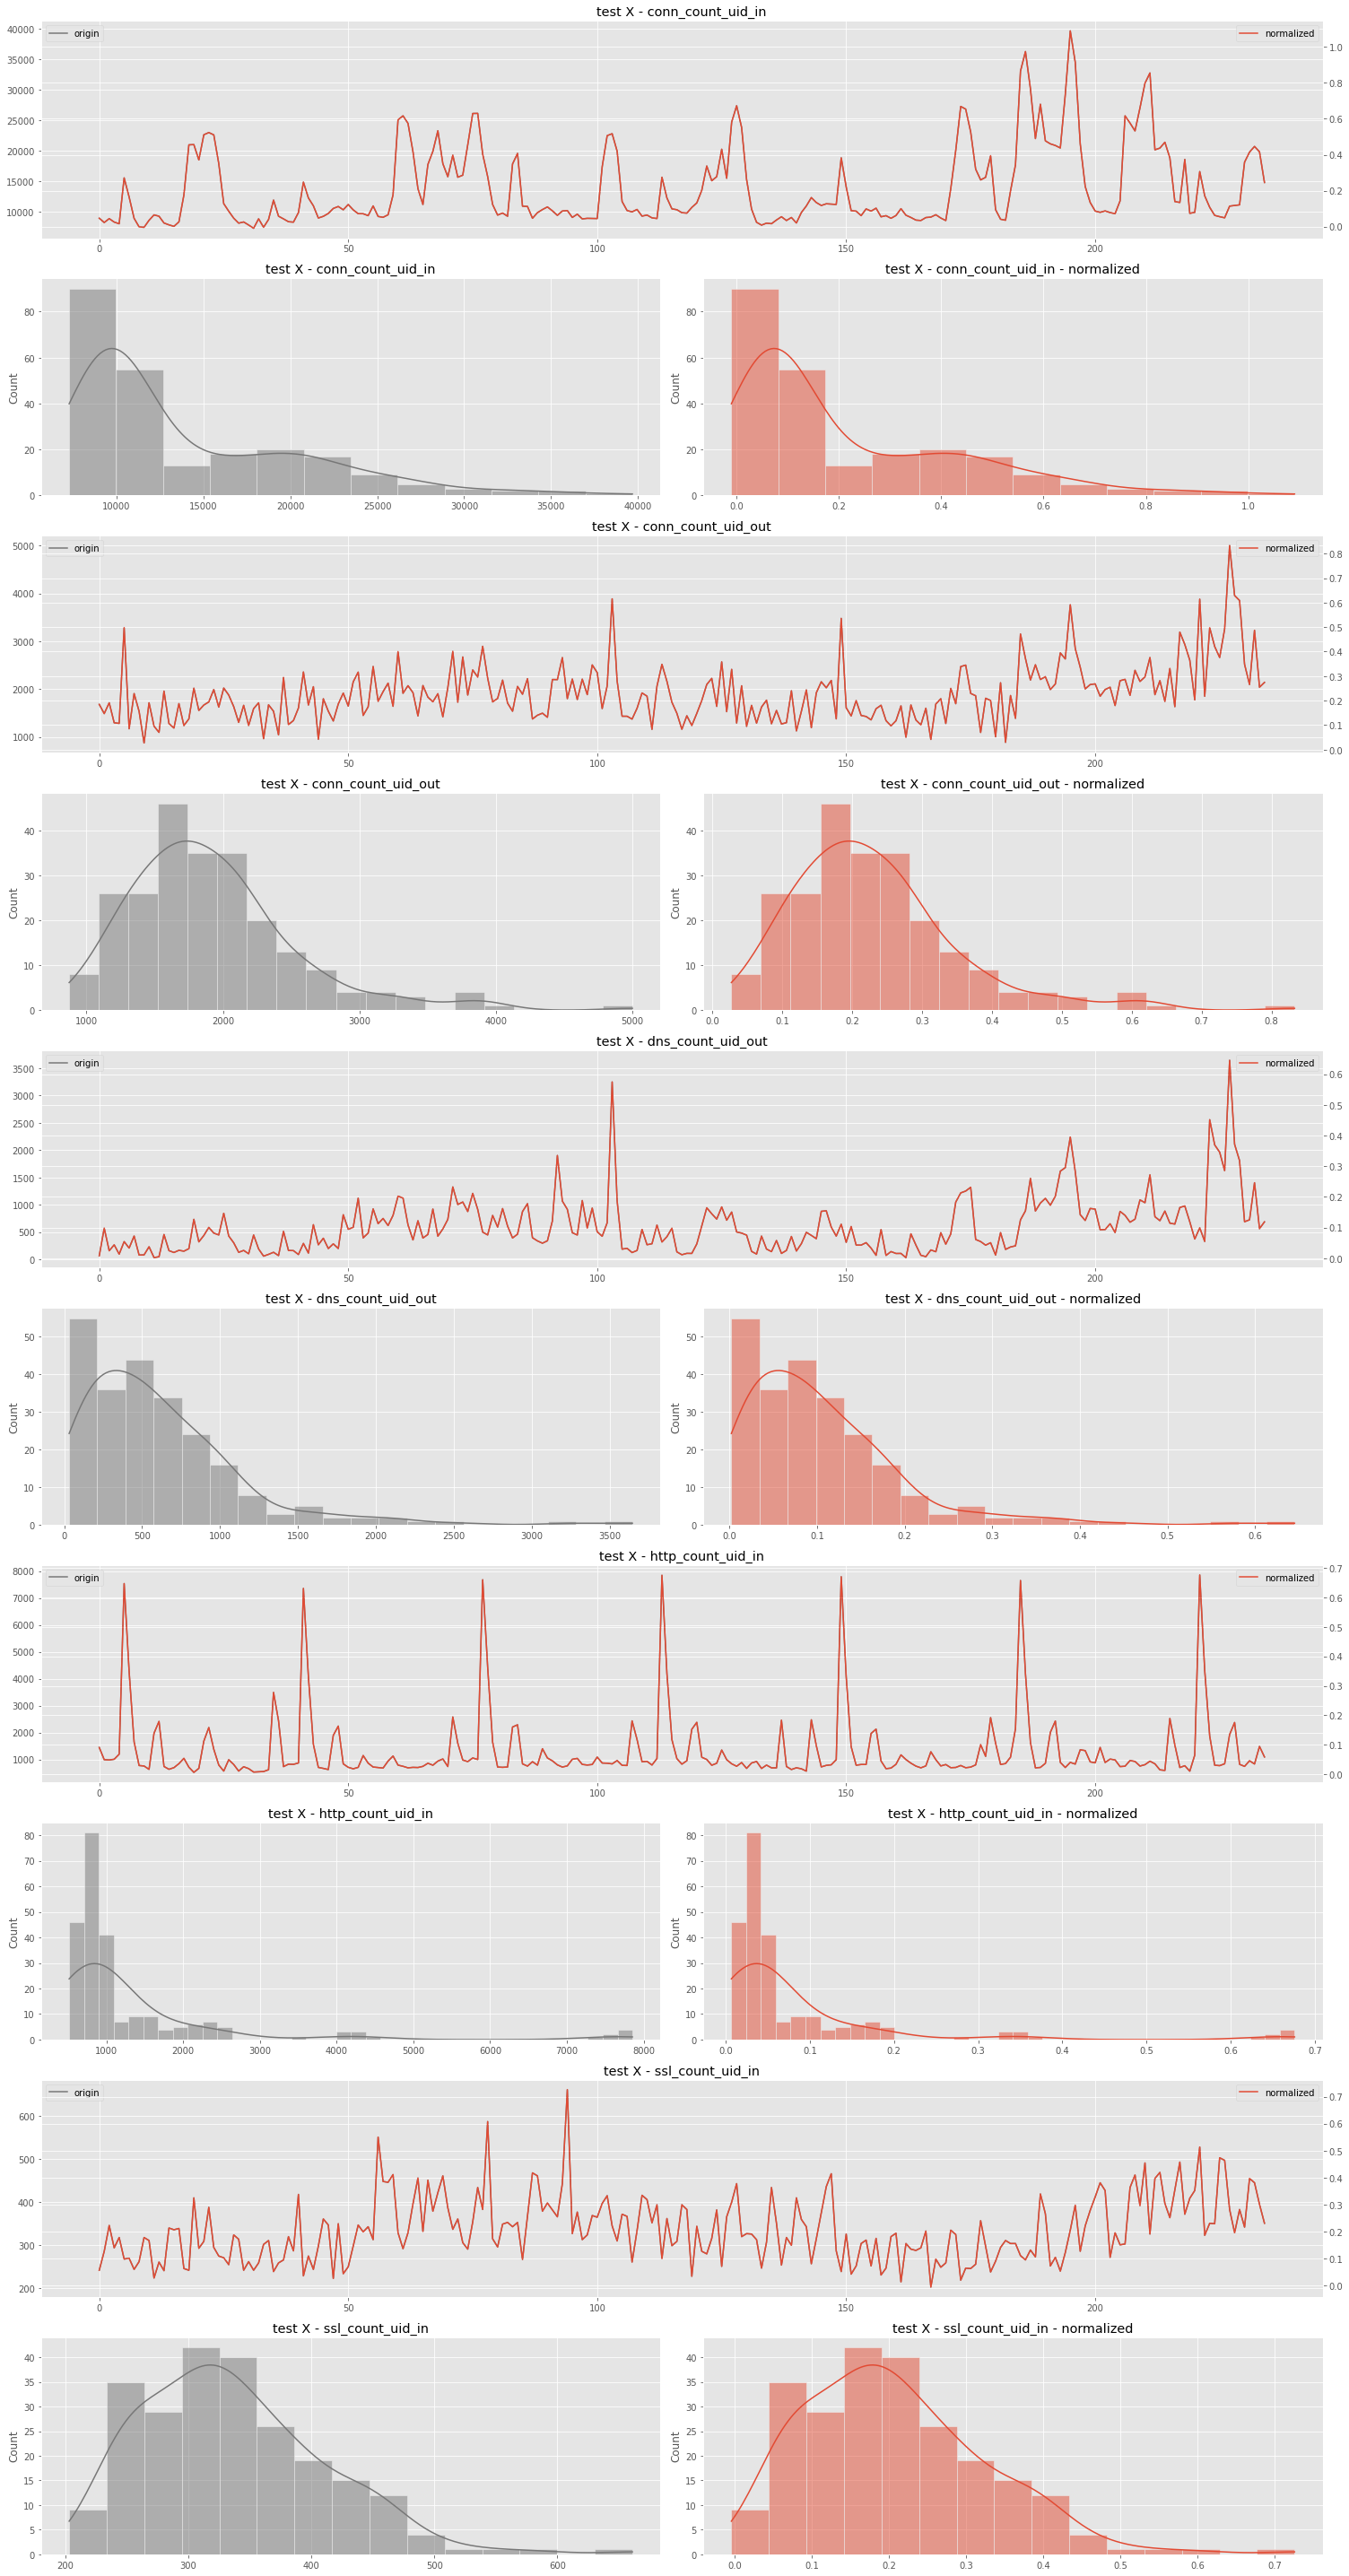

In [5]:
# @giang
class GiangTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, epsilon=1, remove_peak=cfg['remove_peak'], test_stl=cfg['test_stl'], stl_period=cfg['stl_period']):
        self.epsilon = epsilon
        self.remove_peak = remove_peak
        self.test_stl = test_stl
        self.stl_period = stl_period
        self.isfitted = False
    def fit(self, X):
        if self.remove_peak:
            q_min, q_max = np.percentile(X, [25, 75], axis=0)
            iqr = q_max - q_min
            self.iqr_min = q_min - 1.5*iqr
            self.iqr_max = q_max + 1.5*iqr            
        self.isfitted = True
        return self
    def transform(self, X):
        X_ = X.copy()
        if self.test_stl:
            for col in range(X_.shape[1]):
                res = STL(X_[:,col], period=self.stl_period, robust=True).fit()
                X_[:,col] = res.trend + res.seasonal
        if not self.isfitted:
            self.fit(X_)
        if self.remove_peak:
            X_ = np.clip(X_, a_min=self.iqr_min, a_max=self.iqr_max)
        X_ = np.where(X_ < 0, self.epsilon, X_)
        return X_
    def inverse_transform(self, X):
        X_ = X.copy()
        return X_
        
# @giang
transform_pipeline_X = Pipeline([
    ('GiangTransformer', GiangTransformer()),
    ('MinMaxScaler', MinMaxScaler(feature_range=(0, 1)))
])

transform_pipeline_Y = Pipeline([
    ('GiangTransformer', GiangTransformer()),
    ('MinMaxScaler', MinMaxScaler(feature_range=(0, 1)))
])

# # @stevo
# transform_pipeline_X = Pipeline([
#     ('QuantileTransformer', QuantileTransformer(output_distribution='normal')),
#     ('PowerTransformer', PowerTransformer(method='yeo-johnson')),
#     ('MinMaxScaler', MinMaxScaler(feature_range=(0,1))),
# ])

# transform_pipeline_Y = Pipeline([
#     ('QuantileTransformer', QuantileTransformer(output_distribution='normal')),
#     ('PowerTransformer', PowerTransformer(method='yeo-johnson')),
#     ('MinMaxScaler', MinMaxScaler(feature_range=(0,1))),
# ])

# normalized XY train data
data_np_train_X_n = transform_pipeline_X.fit_transform(data_np_train_X)
data_np_train_Y_n = transform_pipeline_Y.fit_transform(data_np_train_Y)

# normalized XY test data
data_np_test_X_n = transform_pipeline_X.transform(data_np_test_X)
data_np_test_Y_n = transform_pipeline_Y.transform(data_np_test_Y)

def plot_hist_orig_norm(prefix, orig, norm, cols, c1, c2):
    
    fig = plt.figure(figsize=(21,2*4*orig.shape[1]))
    gs = GridSpec(2*orig.shape[1], 2, figure=fig)
    
    for i in range(orig.shape[1]):
        
        ax = fig.add_subplot(gs[i*2,:])
        ax.plot(orig[:,i], label='origin', color=c1)
        twinx = ax.twinx()
        twinx.plot(norm[:,i], label='normalized', color=c2)
        ax.set_title('%s%s' % (prefix, cols[i]))
        ax.legend(loc='upper left')
        twinx.legend(loc='upper right')
        
        ax = fig.add_subplot(gs[i*2+1,0])
        sns.histplot(orig[:,i], kde=True, ax=ax, color=c1)
        ax.set_title('%s%s' % (prefix,cols[i]))

        ax = fig.add_subplot(gs[i*2+1,1])
        sns.histplot(norm[:,i], kde=True, ax=ax, color=c2)
        ax.set_title('%s%s - normalized' % (prefix,cols[i]))
    
    fig.tight_layout()
    plt.show()
    
plot_hist_orig_norm('train X - ', data_np_train_X, data_np_train_X_n, data_df_train_X.columns, 'C3', 'C0')
plot_hist_orig_norm('train Y - ', data_np_train_Y, data_np_train_Y_n, data_df_train_Y.columns, 'C3', 'C1')

plot_hist_orig_norm('test X - ', data_np_test_X, data_np_test_X_n, data_df_test_X.columns, 'C3', 'C0')
plot_hist_orig_norm('test Y - ', data_np_test_Y, data_np_test_Y_n, data_df_test_Y.columns, 'C3', 'C1')

In [6]:
def create_tsg(X, Y, forecast_steps, **args):
    if forecast_steps > 1:
        return TimeseriesGenerator(
            X[:-forecast_steps+1],
            Y[forecast_steps-1:],
            **args
        )
    else:
        return TimeseriesGenerator(
            X,
            Y,
            **args
        )

def tsg2tsv(tsg):
    ret = ''
    for i in range(len(tsg)):
        x, y = tsg[i]
        ret += '%s => %s\n' % (x, y)
    return ret

tsg_train = create_tsg(
    data_np_train_X_n,
    data_np_train_Y_n,
    cfg['forecast_steps'],
    **cfg['tsg']
)

tsg_test = create_tsg(
    data_np_test_X_n,
    data_np_test_Y_n,
    cfg['forecast_steps'],
    **cfg['tsg']
)

In [7]:
print('Model typ: GRU')

# >> param mapping Stevo->Giang
cfg_sequence_len = cfg['tsg']['length']
cfg_sequence_len_y = cfg['forecast_len']
multivariate = data_np_train_X_n.shape[1]
cfg_units = cfg['units']
cfg_dropout_rate = cfg['droupout_rate']
cfg_teacher_forcing = cfg['teacher_forcing']
cfg_epochs_patience = cfg['train']['epochs_patience']
# <<

if cfg_teacher_forcing:
    x = Input(batch_shape=(cfg_batch_size, cfg_sequence_len, multivariate))
    h = GRU(units=cfg.units, stateful=True, return_sequences=True)(x)         # activation='tanh'
    h = Dropout(cfg_dropout_rate)(h)
    h = GRU(units=cfg.units, stateful=True, return_sequences=False)(h)
    h = Dropout(cfg_dropout_rate)(h)
    y = Dense(units=multivariate*cfg_sequence_len_y, activation='sigmoid')(h)    
else:
    x = Input(shape=(cfg_sequence_len, multivariate)) 

    h = GRU(units=cfg_units, return_sequences=True)(x)     
    h = Dropout(cfg_dropout_rate)(h)
    h = GRU(units=cfg_units, return_sequences=False)(h)
    h = Dropout(cfg_dropout_rate)(h)
    '''
    h = Dense(units=cfg_units, 
              activation='elu', 
              kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
              bias_regularizer=regularizers.l2(1e-4),
              activity_regularizer=regularizers.l2(1e-5)
             )(x)
    h = Flatten()(h)
    '''      
    # Adding the output layer:
    y = Dense(units=multivariate*cfg_sequence_len_y, activation='sigmoid')(h)
    
model = Model(inputs=x, outputs=y)
print(model.summary())

# compile model
opt = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])     # 'cosine', 'mape'

# tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
earlystops = EarlyStopping(monitor='loss', patience=cfg_epochs_patience, verbose=1)
callbacks_list = [earlystops]

Model typ: GRU
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 5)]           0         
_________________________________________________________________
gru (GRU)                    (None, 24, 60)            12060     
_________________________________________________________________
dropout (Dropout)            (None, 24, 60)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60)                21960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 305       
Total params: 34,325
Trainable params: 34,325
Non-trainable params: 0
___________________________________

In [8]:
# @ stevo
# model = Sequential()
# model.add(
#     Input(
#         batch_shape=(
#             cfg['tsg']['batch_size'],
#             cfg['tsg']['length'],
#             data_np_train_X_n.shape[1]
#         )
#     )
# )
# model.add(
#     LSTM(
#         240,
#         return_sequences=True,
#         stateful=True
#     )
# )
# model.add(Dropout(0.2))
# model.add(
#     LSTM(
#         240,
#         return_sequences=False,
#         stateful=True
#     )
# )
# model.add(Dropout(0.2))
# model.add(
#     Dense(
#         data_np_train_Y_n.shape[1],
#         activation='sigmoid'
#     )
# )
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='mse',
#     metrics=['mse', 'mae', 'mape']
# )
# model.summary()

# # Checkpointing and earlystopping
# checkpoints = ModelCheckpoint(
#     os.path.join('./checkpoints/lstm-{epoch:02d}.hdf5'),
#     monitor='loss',
#     save_best_only=True,
#     mode='auto',
#     verbose=1
# )
# #
# earlystops = EarlyStopping(
#     monitor='loss',
#     patience=25,
#     verbose=1
# )
# #
# callbacks_list = [checkpoints, earlystops]

In [9]:
incremental = False

if incremental:
    for i in range(cfg['train']['epochs_incremental']):
        print('i:%d' % (i+1))
        model.fit(
            tsg_train,
            epochs=1,
            shuffle=False,
            callbacks=callbacks_list,
            batch_size=cfg['tsg']['batch_size'],
            verbose=1
        )
        model.reset_states()
else:
    history = model.fit(
        tsg_train,
        epochs=cfg['train']['epochs'],
        callbacks=callbacks_list,
        batch_size=1,
        verbose=1,
        shuffle=True
    )
    plt.plot(history.history['loss'])

Epoch 1/100
912/912 [==============================] - 9s 10ms/step - loss: 0.0236 - mse: 0.0236 - mae: 0.1052
Epoch 2/100
912/912 [==============================] - 9s 10ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0839
Epoch 3/100
912/912 [==============================] - 9s 10ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0789
Epoch 4/100
912/912 [==============================] - 9s 10ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0765
Epoch 5/100
912/912 [==============================] - 9s 9ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0738
Epoch 6/100
912/912 [==============================] - 7s 8ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0746
Epoch 7/100
912/912 [==============================] - 8s 9ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0729
Epoch 8/100
912/912 [==============================] - 9s 9ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0712
Epoch 9/100
912/912 [==============================] - 9s 10ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0712
Epoch

In [10]:
model_name = os.path.join('models', cfg['model_name'])

if not os.path.exists(model_name):
    os.mkdir(model_name)

# save cfg
with open(os.path.join(model_name, 'cfg.json'), 'w') as cfg_file:
    json.dump(cfg, cfg_file, indent=2, sort_keys=False)

# save the pipeline:
joblib.dump(transform_pipeline_X, os.path.join(model_name, 'sklearn_pipeline_X.pkl'))
joblib.dump(transform_pipeline_Y, os.path.join(model_name, 'sklearn_pipeline_Y.pkl'))

model.save(os.path.join(model_name, 'model.h5'))
print('\nSaved trained model: ', model_name)


Saved trained model:  models/m2-incr-nostl


In [11]:
pred = model.predict(tsg_test, batch_size=cfg['tsg']['batch_size'])
pred = transform_pipeline_Y.inverse_transform(pred)
pred = pd.DataFrame(pred, columns=data_df_test_Y.columns)

if cfg['differential']:
    pred.set_index(
        data_df_test_Y.index[cfg['tsg']['length'] + cfg['forecast_steps'] - 1 + cfg['forecast_steps']:],
        inplace=True
    )
else:    
    pred.set_index(
        data_df_test_Y.index[cfg['tsg']['length'] + cfg['forecast_steps'] - 1:],
        inplace=True
    )

pred = inverse_transform(pred, data_df_test_Y)

fig, axs = plt.subplots(len(pred.columns),1,figsize=(21,4*len(pred.columns)))
i = 0
for col in pred.columns:
    axs[i].plot(data_df_test_Y[col], label='real - %s' % col)
    axs[i].plot(pred[col], label='pred - %s' % col)
    axs[i].legend()
    i+=1
fig.tight_layout()
plt.savefig('plot.png')
plt.show()

In [12]:
predictions = pd.DataFrame()

context_length = cfg['tsg']['length']
forecast_steps = cfg['forecast_steps']

i = 0
while i+context_length+forecast_steps+(forecast_steps if cfg['differential'] else 0) <= data_df_test_Y.shape[0]:

    x = None
    
    if cfg['differential']:
        x = data_df_test_X[i:i+context_length+forecast_steps]
        x = differentiate(x, cfg['forecast_steps'])
    else:
        x = data_df_test_X[i:i+context_length]        
        
    x_np = transform_pipeline_X.transform(x.to_numpy())    

    offset_y = i+context_length+forecast_steps-1+(forecast_steps if cfg['differential'] else 0)
    y = data_df_test_Y[offset_y:offset_y+1].copy(deep=True)
    y.set_index(y.index, inplace=True)
    
    pred = model.predict(x_np[np.newaxis,:], verbose=1, batch_size=1)
    pred = transform_pipeline_Y.inverse_transform(pred)
    
    y[:] = pred

    y = inverse_transform(y, data_df_test_Y[i:offset_y+1])
            
    predictions = predictions.append(y)
    i+=1

1/1 [==============================] - 0s 2ms/step


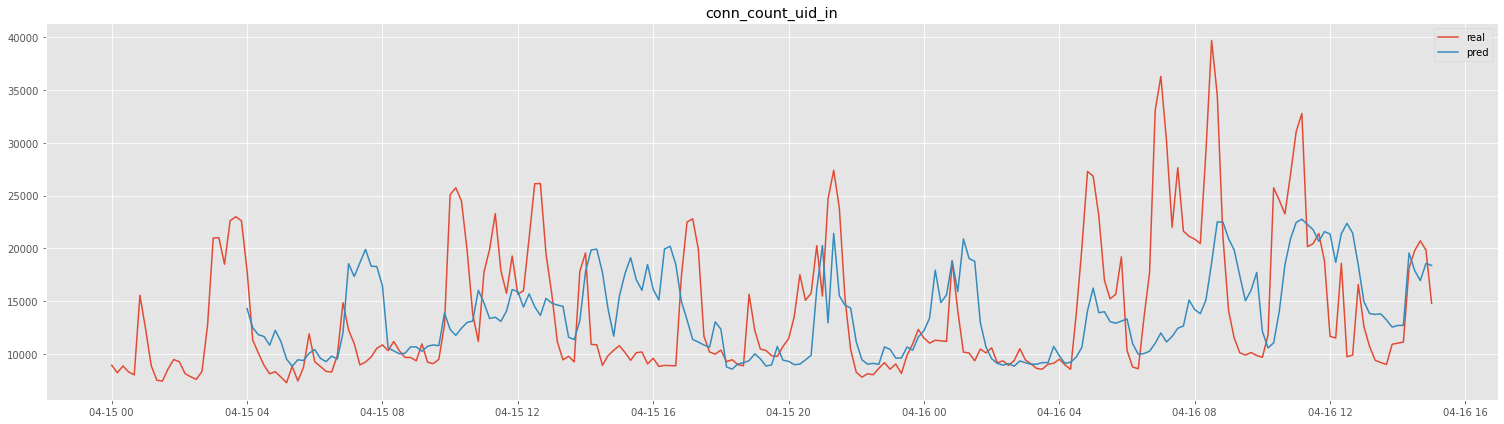

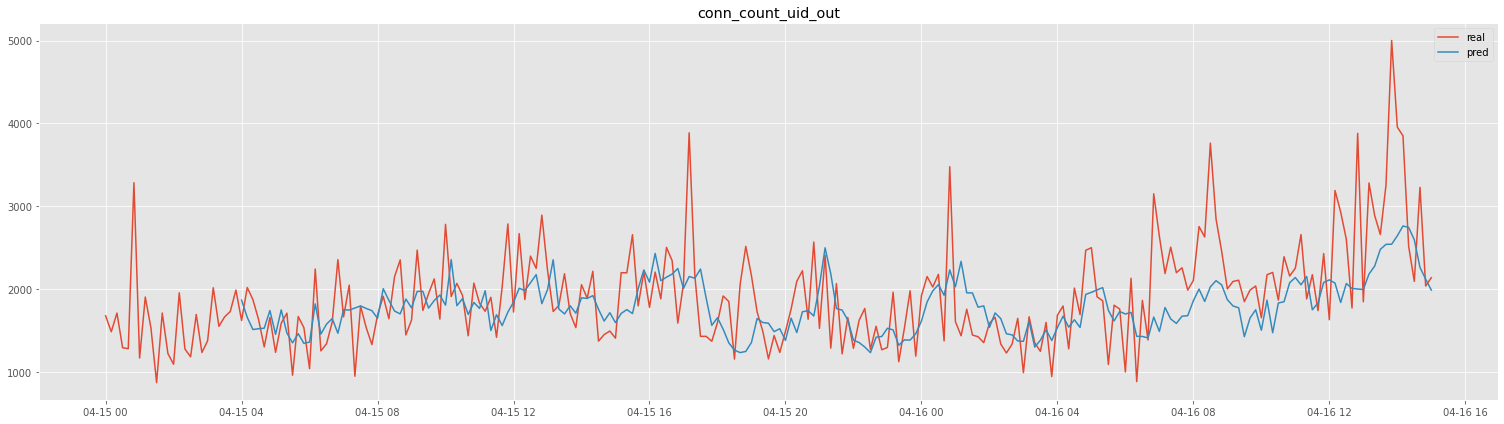

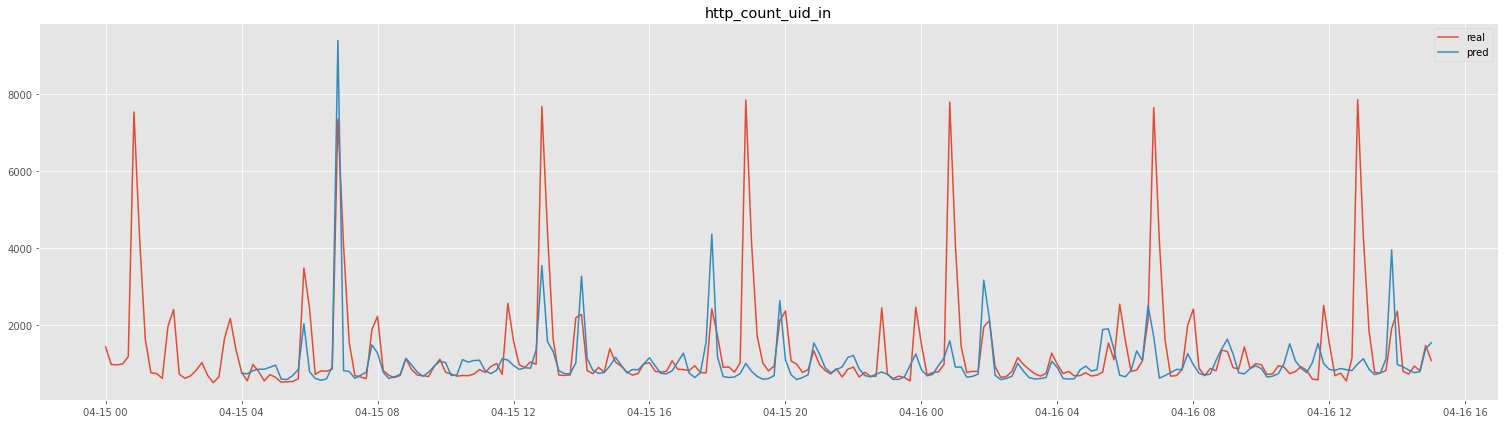

In [13]:
for col in data_df_test_Y.columns:
    fig = plt.figure(figsize=(21,6))
    plt.plot(data_df_test_Y[col],label='real')
    plt.plot(predictions[col],label='pred')
    plt.title(col)
    plt.legend()
    fig.tight_layout()
    plt.show()